In [38]:
import os
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import PIL
import matplotlib.pyplot as plt
import fnmatch
import pathlib


# Désactiver les warnings généraux de Python
warnings.filterwarnings("ignore")

In [39]:
path_to_dataset = 'dataset_new'

In [40]:
batch_size = 30
xray_height = 150
xray_width = 150



In [41]:
# Creating training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    path_to_dataset,
    validation_split=0.3,
    subset="training",
    seed=100, # Determines initial values of weights
    image_size=(xray_height, xray_width),
    batch_size=batch_size
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    path_to_dataset,
    validation_split=0.3,
    subset="validation",
    seed=100, # Determines initial values of weights
    image_size=(xray_height, xray_width),
    batch_size=batch_size
)

# Creating test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    path_to_dataset,
    validation_split=0.1,
    subset="validation",
    seed=200, # Different seed for test set
    image_size=(xray_height, xray_width),
    batch_size=batch_size
)



Found 8000 files belonging to 4 classes.
Using 5600 files for training.
Found 8000 files belonging to 4 classes.
Using 2400 files for validation.
Found 8000 files belonging to 4 classes.
Using 800 files for validation.


In [42]:
categories = train_ds.class_names
print(categories)



['Closed', 'NoYawn', 'Open', 'Yawn']


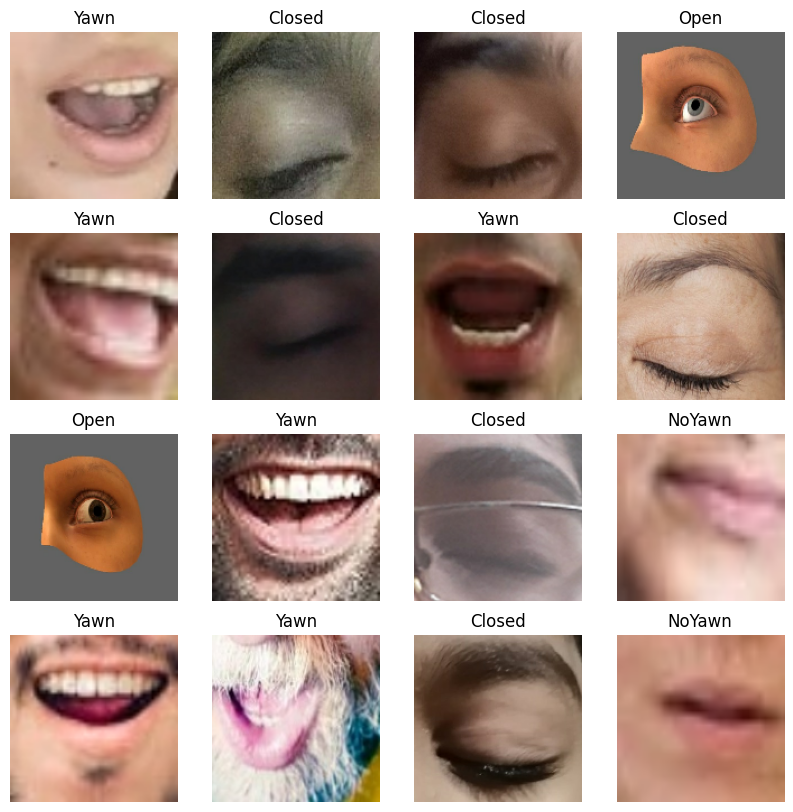

In [43]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(categories[labels[i]])
        plt.axis("off")
        



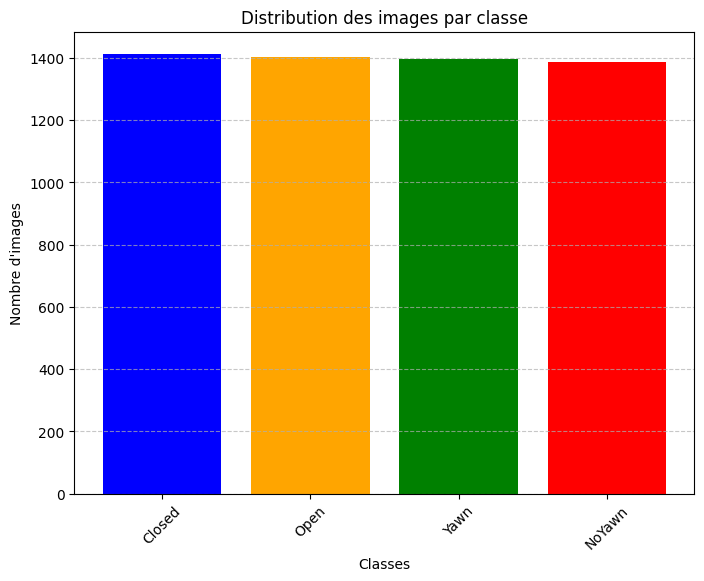

In [44]:
from collections import Counter

# Initialiser un compteur pour chaque classe
class_counts = Counter()

# Parcourir le dataset et compter les occurrences des classes
for images, labels in train_ds:
    class_counts.update(labels.numpy())

# Extraire les noms des classes et leurs fréquences
classes = list(class_counts.keys())  # Index des classes
counts = list(class_counts.values())  # Nombre d'images par classe

# Trier les classes par ordre décroissant de fréquence
sorted_indices = np.argsort(counts)[::-1]
sorted_classes = [categories[i] for i in np.array(classes)[sorted_indices]]
sorted_counts = np.array(counts)[sorted_indices]

# Tracer le graphique en barres
plt.figure(figsize=(8, 6))
plt.bar(sorted_classes, sorted_counts, color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Classes")
plt.ylabel("Nombre d'images")
plt.title("Distribution des images par classe")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [45]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # Caching
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE) # Prefetching
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE) # Prefetching




In [46]:


num_classes = len(categories)

model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(150, 150, 3)), # Première couche avec input shape
    layers.MaxPooling2D(),  # Réduction de la taille : 150x150 -> 75x75

    layers.Conv2D(32, 3, padding='same', activation='relu'),  
    layers.MaxPooling2D(),  # 75x75 -> 37x37

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),  # 37x37 -> 18x18

    layers.Conv2D(128, 3, padding='same', activation='relu'),  # Ajout d'une couche 128 filtres
    layers.MaxPooling2D(),  # 18x18 -> 9x9

    layers.Conv2D(128, 3, padding='same', activation='relu'),  # Deuxième couche 128 filtres
    layers.MaxPooling2D(),  # 9x9 -> 4x4

    layers.Flatten(),  # Passage à un vecteur 1D (4*4*128 = 2048 paramètres)
    layers.Dense(128, activation='relu'),  # Couche dense avec 128 neurones
    layers.Dense(num_classes, activation='softmax')  # Couche de sortie avec softmax pour classification multiclasse
])



In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [48]:
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507,812 (1.94 MB)

 Trainable params: 507,812 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs
)


Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.6335 - loss: 4.4583 - val_accuracy: 0.9108 - val_loss: 0.2947
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.9301 - loss: 0.2250 - val_accuracy: 0.9096 - val_loss: 0.3001
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9551 - loss: 0.1410 - val_accuracy: 0.9504 - val_loss: 0.1866
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.9616 - loss: 0.1204 - val_accuracy: 0.9583 - val_loss: 0.1482
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9702 - loss: 0.0865 - val_accuracy: 0.9538 - val_loss: 0.1700
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.9768 - loss: 0.0763 - val_accuracy: 0.9579 - val_loss: 0.2084
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9701 - loss: 0.0933 - val_accuracy: 0.9579 - val_loss: 0.1773
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.9817 - loss: 0

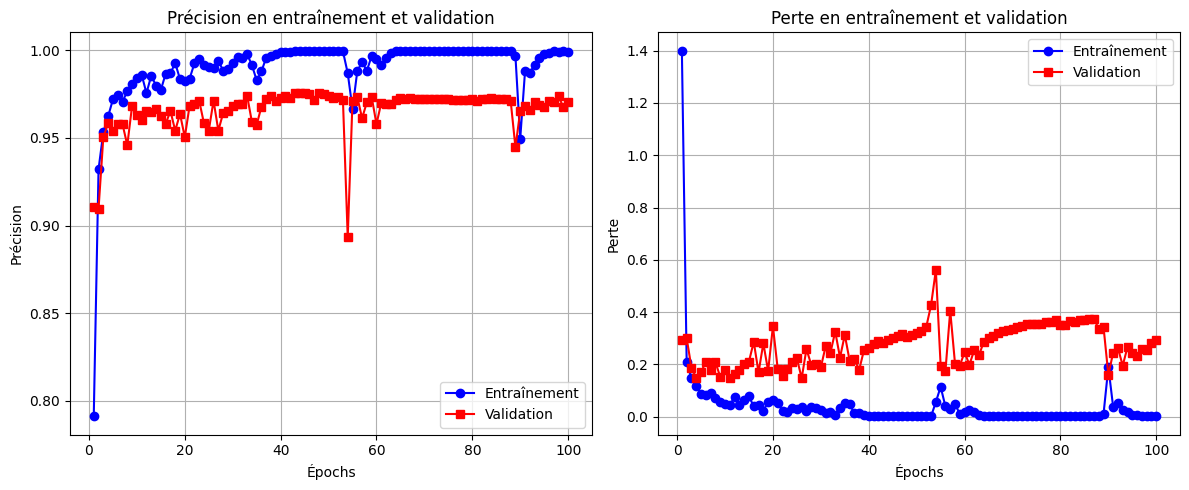

In [50]:


accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']
loss = history.history['loss']
valid_loss = history.history['val_loss']

no_of_epochs = range(1, len(accuracy) + 1)  # Ajustement de la plage

plt.figure(figsize=(12, 5))

# Graphique de l'Accuracy
plt.subplot(1, 2, 1)
plt.plot(no_of_epochs, accuracy, 'o-', label='Entraînement', color='blue')
plt.plot(no_of_epochs, valid_accuracy, 's-', label='Validation', color='red')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.title('Précision en entraînement et validation')
plt.legend(loc='best')
plt.grid(True)

# Graphique de la Loss
plt.subplot(1, 2, 2)
plt.plot(no_of_epochs, loss, 'o-', label='Entraînement', color='blue')
plt.plot(no_of_epochs, valid_loss, 's-', label='Validation', color='red')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.title('Perte en entraînement et validation')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()


In [51]:
# Evaluate the model on the validation dataset
val_loss, val_acc = model.evaluate(valid_ds, verbose=2)
print(f'\nValidation loss: {val_loss}')
print(f'\nValidation accuracy: {val_acc}')


80/80 - 2s - 22ms/step - accuracy: 0.9704 - loss: 0.2912

Validation loss: 0.2911785840988159

Validation accuracy: 0.9704166650772095


In [52]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f'\nTest loss: {test_loss}')
print(f'\nTest accuracy: {test_acc}')


27/27 - 1s - 28ms/step - accuracy: 0.9962 - loss: 0.0723

Test loss: 0.07230180501937866

Test accuracy: 0.9962499737739563


In [53]:
model.save('somnolance.keras')